# Predict ice hockey game result with machine learning

The use of data analytics and statistics to predict outcome of sport events is nothing new and is of course used by the betting companies. You look at trends, table position, head-to-head results etc. And for the individual players, dont forget the most important aspect: This vague "feeling".  

My "feeling" is normally not very accurate, and thus I wanted to set up a machine learning model that predicted the outcome of ice hockey games. Maybe this could help me to improve accuracy in my predictions, and not loose that much money. 

This notebook describes how I developed a random forest classifier to predict outcome of ice hockey games in the swedish 1st and 2nd league. I will also apply the model to the season results to see how it would have performed.

I will use two datasets collected with the package ```swehockey_scraper``` which collects data from www.stats.swehockey.se. 
Details about the package is found here [github project for ice-hockey-analysis](https://github.com/msjoelin/swehockey_scraper)

Steps:
1. Import data
2. Exploratory analysis
3. Prepare data for the machine learning model
4. Train model
5. Evaluate performance
6. Apply model to result current season and 

So let's start!

### 1) Import  packages and data


In [1]:
import numpy as np
import pandas as pd

# sklearn will be used to build the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To save the model
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [2]:
# Import game data. Only keep relevant columns
url_games = 'https://raw.githubusercontent.com/msjoelin/icehockey_analysis/master/data/df_games.csv'

df_games = pd.read_csv(url_games, error_bad_lines=False)[['date', 'game', 'score', 'league', 'season', 'game_id', 
                'home', 'away', 'score_home', 'score_away', 'result']]

print(df_games.shape[0], " matches imported")

df_games.head()

9184  matches imported


,date,game,score,league,season,game_id,home,away,score_home,score_away,result
0,2019-09-14,Frölunda HC - Brynäs IF,2 - 5,shl,2019/20,441805,Frölunda HC,Brynäs IF,2,5,away
1,2019-09-14,Skellefteå AIK - IK Oskarshamn,5 - 4,shl,2019/20,441808,Skellefteå AIK,IK Oskarshamn,5,4,draw
2,2019-09-14,Leksands IF - IF Malmö Redhawks,5 - 2,shl,2019/20,441809,Leksands IF,IF Malmö Redhawks,5,2,home
3,2019-09-14,Djurgårdens IF - Linköping HC,4 - 2,shl,2019/20,441803,Djurgårdens IF,Linköping HC,4,2,home
4,2019-09-14,Färjestad BK - Örebro HK,4 - 6,shl,2019/20,441804,Färjestad BK,Örebro HK,4,6,away


In [3]:
# Import team data
url_teams = 'https://raw.githubusercontent.com/msjoelin/icehockey_analysis/master/data/df_teams.csv'

df_teams = pd.read_csv(url_teams, error_bad_lines=False)[['game_id', 'team', 'h_a', 
                     'win_R5', 'draw_R5', 'lost_R5',  
                     'H2H_W', 'H2H_D', 'H2H_L',
                    'scored_avg_R5', 'conceded_avg_R5',
                    'points_cum_prev_avg', 'points_cum_h_a_prev_avg']]

print(df_teams.shape[0], " teamrows imported")

df_teams.head()

18368  teamrows imported


,game_id,team,h_a,win_R5,draw_R5,lost_R5,H2H_W,H2H_D,H2H_L,scored_avg_R5,conceded_avg_R5,points_cum_prev_avg,points_cum_h_a_prev_avg
0,422474,AIK,away,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN,NaN
1,422481,AIK,home,0.000000,0.000000,1.000000,0.0,0.0,0.0,3.0,7.000000,0.000000,NaN
2,422484,AIK,away,0.500000,0.000000,0.500000,0.0,0.0,0.0,4.5,5.500000,1.500000,0.0
3,422494,AIK,home,0.333333,0.333333,0.333333,0.0,0.0,0.0,4.0,4.333333,1.666667,3.0
4,422499,AIK,away,0.500000,0.250000,0.250000,0.0,0.0,0.0,4.5,3.750000,2.000000,1.0


Following columns were selected to be included in the analysis: 

* Win_R5 / Draw_R5 / Lost_R5   
Ratio of won, draw or lost games the last 5 games
* H2H_W/D/L  
Head to head ratio
* points_cum_prev_avg  
Average number of points per game during the season so far
* points_cum_h_a_prev_avg  
Average number of points per game during the season so far when playing home or away

Next step is to join data for home and away teams to the game dataset. These columns will be used for predictions later on. In order to do so, we are splitting up the teams data into home and away and adding suffix to column names. This data is then added to the games data into the new dataframe ```df_games_trend```

In [4]:
# Split into home and away data
df_home = df_teams[df_teams['h_a']=='home'].copy().drop(['team', 'h_a'], axis=1).add_suffix('_home').rename(columns={"game_id_home": "game_id"})
df_away = df_teams[df_teams['h_a']=='away'].copy().drop(['team', 'h_a'], axis=1).add_suffix('_away').rename(columns={"game_id_away": "game_id"})

df_games_trend = pd.merge(df_games, df_home, 
                   on='game_id', how='left')

df_games_trend = pd.merge(df_games_trend, df_away, 
                   on='game_id', how='left')

# H2H values are now duplicates, so remove one of them and rename the other one
df_games_trend=df_games_trend.drop(['H2H_W_away', 'H2H_D_away', 'H2H_L_away'], axis=1)

df_games_trend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9183
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          9184 non-null   object 
 1   game                          9184 non-null   object 
 2   score                         9184 non-null   object 
 3   league                        9184 non-null   object 
 4   season                        9184 non-null   object 
 5   game_id                       9184 non-null   int64  
 6   home                          9184 non-null   object 
 7   away                          9184 non-null   object 
 8   score_home                    9184 non-null   int64  
 9   score_away                    9184 non-null   int64  
 10  result                        9184 non-null   object 
 11  win_R5_home                   9184 non-null   float64
 12  draw_R5_home                  9184 non-null   float64
 13  los

That was it. We have now prepared the data that should be used for predictions. Next step is to explore the data. 

### 2) Exploratory analysis

As always the first step is to explore the data. 

In [5]:
df_games_trend.describe()

,game_id,score_home,score_away,win_R5_home,draw_R5_home,lost_R5_home,H2H_W_home,H2H_D_home,H2H_L_home,scored_avg_R5_home,conceded_avg_R5_home,points_cum_prev_avg_home,points_cum_h_a_prev_avg_home,win_R5_away,draw_R5_away,lost_R5_away,scored_avg_R5_away,conceded_avg_R5_away,points_cum_prev_avg_away,points_cum_h_a_prev_avg_away
count,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.00000,9184.000000,9184.000000,9009.000000,8832.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9007.000000,8832.000000
mean,256957.251089,2.935105,2.430205,0.375528,0.209776,0.395641,0.363284,0.202434,0.38169,2.603061,2.657571,1.467175,1.739727,0.393198,0.214315,0.373214,2.652134,2.596833,1.493979,1.218418
std,141346.628142,1.717349,1.559005,0.242882,0.195283,0.245336,0.227754,0.174017,0.23556,0.899425,0.913987,0.473430,0.579692,0.246756,0.197301,0.241922,0.921188,0.894860,0.476068,0.566392
min,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123022.750000,2.000000,1.000000,0.200000,0.000000,0.200000,0.230769,0.071429,0.25000,2.000000,2.000000,1.181818,1.409091,0.200000,0.000000,0.200000,2.000000,2.000000,1.200000,0.875000
50%,301008.500000,3.000000,2.000000,0.400000,0.200000,0.400000,0.363636,0.200000,0.37500,2.600000,2.600000,1.480769,1.750000,0.400000,0.200000,0.400000,2.600000,2.600000,1.500000,1.214286
75%,389831.250000,4.000000,3.000000,0.600000,0.400000,0.600000,0.500000,0.285714,0.50000,3.200000,3.200000,1.750000,2.090909,0.600000,0.400000,0.600000,3.200000,3.200000,1.764706,1.533333
max,442238.000000,12.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,8.000000,10.000000,3.000000,3.000000,1.000000,1.000000,1.000000,10.000000,7.500000,3.000000,3.000000


The dataset contains from 2007 for SHL and Allsvenskan.

In [6]:
print(df_games_trend['season'].value_counts())
print(df_games_trend['league'].value_counts())

2015/16    728
2019/20    728
2017/18    728
2018/19    728
2016/17    728
2010/11    694
2014/15    694
2013/14    694
2011/12    694
2009/10    694
2012/13    694
2007/08    690
2008/09    690
Name: season, dtype: int64
allsvenskan    4724
shl            4460
Name: league, dtype: int64


In [7]:
df_games_trend.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, game_id to points_cum_h_a_prev_avg_away
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   game_id                       20 non-null     float64
 1   score_home                    20 non-null     float64
 2   score_away                    20 non-null     float64
 3   win_R5_home                   20 non-null     float64
 4   draw_R5_home                  20 non-null     float64
 5   lost_R5_home                  20 non-null     float64
 6   H2H_W_home                    20 non-null     float64
 7   H2H_D_home                    20 non-null     float64
 8   H2H_L_home                    20 non-null     float64
 9   scored_avg_R5_home            20 non-null     float64
 10  conceded_avg_R5_home          20 non-null     float64
 11  points_cum_prev_avg_home      20 non-null     float64
 12  points_cum_h_a_prev_avg_home  20 non-nu

Next step is to add some variables in order to analyze correlation of outcome vs attributes. 
There will be three new columns, each having 1 or 0 if the outcome was home, draw or away. 


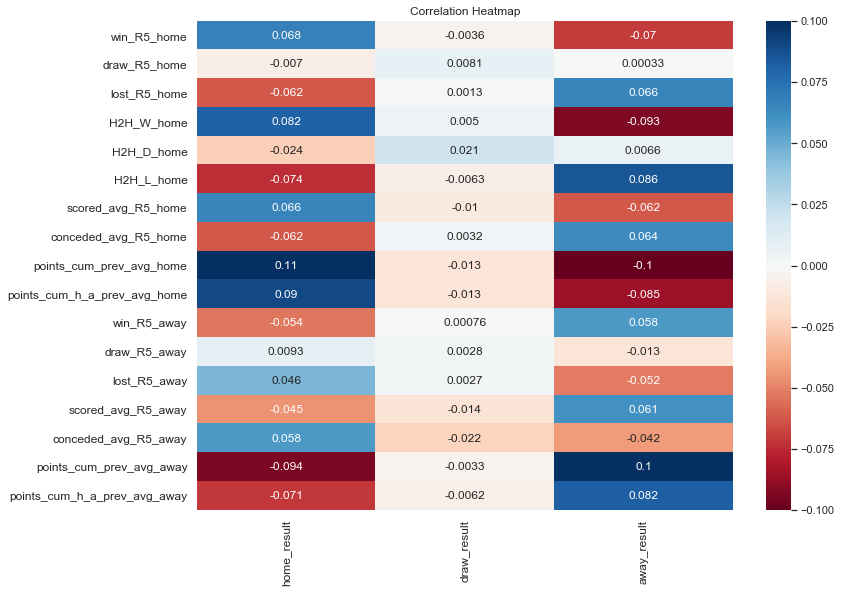

In [8]:
# Introduce binary outcome variables
df_games_trend['home_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'home'), 'home_result'] = 1

df_games_trend['draw_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'draw'), 'draw_result'] = 1

df_games_trend['away_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'away'), 'away_result'] = 1

# Heatmap for correlations
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_games_trend.corr()[['home_result', 'draw_result', 'away_result']][3:20],
               annot = True, 
               cmap = 'RdBu',
               vmin = -0.1, 
               vmax = 0.1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows correlation between result and different attributes. 

* Highest correlation for home and away win is the total cumulative points in the season. Not very surprising. 
* Importance of form for the home team has higher correlation than for away team. 


### 3. Prepare data for the machine learning model

After the quick cleaning and exploration of the data, it's time to set up the machine learning model.  
Out dataframe contains some null values, coming from games in the beginning of the season where no trends can be calculated. These are dropped, together with the columns that was created for the correlation chart. 

The data for current season is saved to another dataframe, as this will be used to evaluate the final performance of the model and thus should not be used when training the model.

In [9]:
df_model = df_games_trend[~df_games_trend.isnull().any(axis=1)].reset_index(drop=True)
df_model  = df_model.drop(['home_result','draw_result', 'away_result'], axis=1)

df_2019 = df_model[df_model['season']=='2019/20']
df_model = df_model[df_model['season']!='2019/20'].reset_index(drop=True)

print("Data current season: " + str(df_2019.shape[0]))
print("Data for modeling: " + str(df_model.shape[0]))


Data current season: 697
Data for modeling: 8107


#### Check for imbalance
A balanced dataset would give us about 1/3 per each home, away and draw outcome.  

Now we have a skewed distribution, and thus a baseline, primitive model only predicting "home" all the time would be right 50% of the times. This is important to keep in mind when evaluating the final outcome. The trained model should at least be better than this. 

In [10]:
df_model['result'].value_counts(normalize=True)

home    0.472555
away    0.308869
draw    0.218577
Name: result, dtype: float64

#### Prepare data for the model

This is a classification problem. Random forest is in general a popular algorithm to use. Random forest is kind of an advanced decision tree. The classifier from sklearn will be used. For this to work, the classes must be turned into factors. 

In [11]:
#Creating the dependent variable class
mapping = {'home': 0, 'draw': 1, 'away': 2}
df_model = df_model.replace({'result': mapping})

#### Split into dependent and independent variables


In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          8107 non-null   object 
 1   game                          8107 non-null   object 
 2   score                         8107 non-null   object 
 3   league                        8107 non-null   object 
 4   season                        8107 non-null   object 
 5   game_id                       8107 non-null   int64  
 6   home                          8107 non-null   object 
 7   away                          8107 non-null   object 
 8   score_home                    8107 non-null   int64  
 9   score_away                    8107 non-null   int64  
 10  result                        8107 non-null   int64  
 11  win_R5_home                   8107 non-null   float64
 12  draw_R5_home                  8107 non-null   float64
 13  los

The dependent variable (what should be predicted) is in column 10, and the independent variables are in columns 11 to 27. 
A third variable with attributes are stored in the variable ```info```.

In [13]:
#Splitting the data into independent and dependent variables
X = df_model.iloc[:,11:].values
y = df_model.iloc[:,10].values
info = df_model.iloc[:,0:9].values

X_2019 = df_2019.iloc[:,11:].values
y_2019 = df_2019.iloc[:,10].values
info_2019 = df_2019.iloc[:,0:9].values


The data is split into train and test data, splitted 80/20.  
Considering our imbalanced data set, the input ``stratify =y`` is used in the function.  

Finally the independent variables has to be scaled as they are of different scales. This is done with the standard scaler in sklearn library. The mean value for each variable is subtracted and then divided by its unit variance . 

In [14]:
# Random state = 21 (random number)
X_train, X_test, y_train, y_test, info_train, info_test  = train_test_split(X, y, info, 
                                                                            test_size = 0.2, stratify = y, random_state = 21)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_2019 = scaler.transform(X_2019)

### 4. Train model

Data is ready to be used to train the model. 

In [1]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

# save the model to disk
#filename = "C:/Users/marcu/Documents/projects/icehockey/ml_models/rf_predict_game.sav"
#pickle.dump(rf, open(filename, 'wb'))


NameError: name 'RandomForestClassifier' is not defined

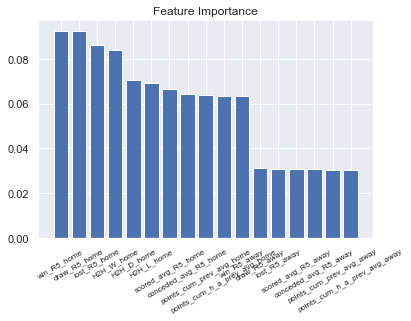

In [16]:
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = ['win_R5_home', 'draw_R5_home', 'lost_R5_home', 
         'H2H_W_home', 'H2H_D_home', 'H2H_L_home', 
         'scored_avg_R5_home', 'conceded_avg_R5_home',
         'points_cum_prev_avg_home', 'points_cum_h_a_prev_avg_home',
         'win_R5_away', 'draw_R5_away', 'lost_R5_away',
         'scored_avg_R5_away', 'conceded_avg_R5_away',
         'points_cum_prev_avg_away', 'points_cum_h_a_prev_avg_away']


# Barplot: Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=30, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

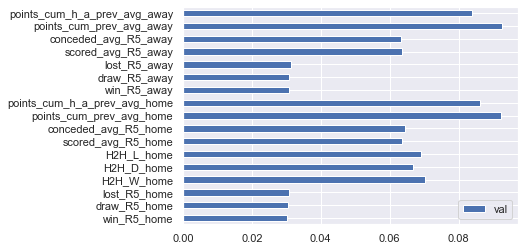

In [24]:
df = pd.DataFrame({'val': importances}, index=names)
ax = df.plot.barh(y='val')


### 5. Evaluate performance

Time to evaluate the performance of the model. This is done with precision and recall:  

* Precision: Proportion of positive predictions that was correct
* Recall: Proportion of actual positives that was identified

In [25]:
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.81      0.62       766
           1       0.27      0.03      0.06       355
           2       0.42      0.28      0.33       501

    accuracy                           0.48      1622
   macro avg       0.40      0.37      0.34      1622
weighted avg       0.42      0.48      0.41      1622



* If the model predicts 0 (home win), this is correct 1/2 of the times. The model identifies 81% of all home wins.  
* If the model predicts 1 (draw), this is only correct in 27% of the cases. The model has a hard time to identify these (only 3 % are discovered) 
* If the model predicts 2 (away), this is correct in 42 % of the cases. 28 % of the away wins are identified.

The reason for low numbers for draw is that this sign is the least frequent. Thus, the model tends to choose either home or away wins to a higher extent. 


### Would using the model current season bring any money?

Now to the interesting part: Would the model bring any money?
We are testing the model on the data for 2019. 

In [ ]:
y_pred2019_rf = rf.predict(X_2019)
y_pred2019_rf_prob = rf.predict_proba(X_2019)

df_2019 = pd.DataFrame(info_2019)

df_2019.columns = ['date', 'game', 'score', 'league', 'season', 'game_id', 'home', 'away','score_home']

# Set the outcome variables and probabilities
df_2019['actual'] = y_2019
df_2019['predicted'] = y_pred2019_rf
df_2019['prob_home'] = y_pred2019_rf_prob[:,0]
df_2019['prob_draw'] = y_pred2019_rf_prob[:,1]
df_2019['prob_away'] = y_pred2019_rf_prob[:,2]

# Map back sign outcome
mapping = {0:'home', 1:'draw', 2:'away'}
df_2019 = df_2019.replace({'actual': mapping, 'predicted': mapping})

df_2019['correct']=0
df_2019.loc[df_2019['actual']==df_2019['predicted'],'correct']=1

# Check mean values by sign
print("Correct ratio by prediction")
df_2019.groupby(['predicted'])['correct'].mean()

The accuracy looks pretty good. 
For a proper evaluation, we need the odds per outcome. This data has been collected with the notebook 
https://github.com/msjoelin/icehockey_analysis/blob/master/get_odds_liverattning.ipynb

In [ ]:
# Add odds data to games
url_odds = 'https://raw.githubusercontent.com/msjoelin/icehockey_analysis/master/data/sweden_odds.csv'

df_odds = pd.read_csv(url_odds, error_bad_lines=False, sep=',', decimal=',')

df_2019_odds = pd.merge(df_2019, df_odds[['date', 'home', 'away', 'odds_1', 'odds_X', 'odds_2', 'odds_outcome']],
                   on=['date', 'home', 'away'], how='left')

# Add columns for return
df_2019_odds['return'] = df_2019_odds['odds_outcome']*df_2019_odds['correct']
df_2019_odds.loc[df_2019_odds['correct']==0,'return'] = -1

df_2019_odds.head()

In [ ]:
sns.barplot(x='predicted', y='return', 
            estimator = sum, data=df_2019_odds, ci=None)

In [ ]:
df_2019_odds.to_csv("C:/Users/marcu/Documents/projects/icehockey/data/df_2019_odds.csv", index=False)